In [1]:
from database import Database
from database import LoadDatabase
from scipy.stats import norm
import math

DB = LoadDatabase()

In [2]:
class contestInfo:
    def __init__(self, contestId, contestTime, TopcoderRating, CodeforcesRating, expectedPlace, place):
        self.contestId = contestId
        self.contestTime = contestTime
        self.TopcoderRating = TopcoderRating
        self.CodeforcesRating = CodeforcesRating
        self.expectedPlace = expectedPlace
        self.place = place
    
    def __str__(self):
        return '[contest = %d, topcoder rating = %lf, codeforces rating = %d]' % (self.contestId, 
                                                                                self.newTopcoderRating,
                                                                                self.newCodeforcesRating)
    
def TopcoderRatingSystem(data, errFun, startRating = 1000, startVolatility = 500, capConstant1 = 150, capConstant2 = 2000, weightConstant1 = 0.7, weightConstant2 = 0.2,
    weightDecrease = [[1500, 0.95], [2000, 0.9], [2500, 0.8], [3000, 0.7]], verbose = True, **kwargs):

    contestsIds = list(data.contests.index)
    contestsIds = sorted(contestsIds, key = lambda x: data.contests.loc[x].startTime)
    
    ans, ratings, volatility, matches = {}, {}, {}, {}
    userHistory = {}
    
    def sqr(a):
        return a * a
    
    def getMatches(user):
        if user not in matches:
            matches[user] = 0
        return matches[user]
    
    def getRating(user):
        if user not in ratings:
            ratings[user] = startRating;
        return ratings[user]
    
    def getVolatility(user):
        if user not in volatility:
            volatility[user] = startVolatility
        return volatility[user]

    def pushHistory(user, contestId, rating, expectedPlace, place):
        if user not in userHistory:
            userHistory[user] = []
        userHistory[user].append(contestInfo(contestId, data.contests.loc[contestId].startTime, 
                                             rating, data.standings[contestId].loc[user].newRating,
                                             expectedPlace, place))
    
    def getCompetitionFactor(rating, volatility):
        n = len(rating)
        avgRating = sum(rating) / n
        volatilitySum, ratingSum = 0, 0
        
        for i in range(n):
            volatilitySum += sqr(volatility[i])
            ratingSum += sqr(rating[i] - avgRating)
        return math.sqrt(volatilitySum / n + ratingSum / (n - 1))

    def getExpectedRank(rating, volatility):
        expectedRank = [0.5] * n
        for i in range(n):
            for j in range(n):
                tmp = (rating[j] - rating[i]) / math.sqrt(2 * (sqr(volatility[i]) + sqr(volatility[j])))
                tmp = math.erf(tmp) + 1
                expectedRank[i] += tmp / 2.
        return expectedRank
    
    def getWeight(user):
        weight = weightConstant1 / (getMatches(user) + 1)
        weight += weightConstant2
        weight = 1 / (1 - weight) - 1
        
        coef = 1.
        rating = getRating(user)
        for s in weightDecrease:
            if s[0] <= rating and s[1] < coef:
                coef = s[1]
        return coef * weight
    
    def getCap(user):
        return capConstant1 + capConstant2 / (getMatches(user) + 2)
    
    def getError(expRank, actRank):
        ret = 0
        n = len(expRank)

        for s in range(n):
            ret += errFun(expRank[s], actRank[s])
        return ret / n
    
    for contest in contestsIds:
        if contest > 200:
            break

        df = data.standings[contest]
        n = df.shape[0]
        user = list(df.index)
        rank, oldRating, oldVolatility = [], [], []

        for i in range(n):
            rank.append(df.iloc[i]["rank"])
            oldRating.append(getRating(user[i]))
            oldVolatility.append(getVolatility(user[i]))

        competitionFactor = getCompetitionFactor(oldRating, oldVolatility)
        expectedRank = getExpectedRank(oldRating, oldVolatility)
        ans[contest] = getError(expectedRank, rank)
        
        for i in range(n):
            ePerf = -norm.ppf((expectedRank[i] - 0.5) / n)
            aPerf = -norm.ppf((rank[i] - 0.5) / n)
            
            perf = oldRating[i] + competitionFactor * (aPerf - ePerf)
            weight = getWeight(user[i])
            cap = getCap(user[i])
            
            
            newRating = (oldRating[i] + weight * perf) / (1 + weight)
            if newRating > oldRating[i] + cap:
                newRating = oldRating[i] + cap
            
            if oldRating[i] > newRating + cap:
                newRating = oldRating[i] - cap
            
            matches[user[i]] += 1
            ratings[user[i]] = newRating
            volatility[user[i]] = math.sqrt(sqr(oldVolatility[i]) / (weight + 1) + sqr(newRating - oldRating[i]) / weight)
            pushHistory(user[i], contest, newRating, expectedRank[i], rank[i])

        if verbose and contest % 5 == 0:
            print('done contest %d' % contest)
    return ans, userHistory

In [7]:
def errFun(a, b):
    return math.log(max(a, b) / min(a, b))

contestErrors, userHistory = TopcoderRatingSystem(DB, errFun)

done contest 30
done contest 35
done contest 40
done contest 55
done contest 60
done contest 65
done contest 70
done contest 75
done contest 80
done contest 85
done contest 90
done contest 95
done contest 105
done contest 110
done contest 115
done contest 135
done contest 140
done contest 145
done contest 150
done contest 155
done contest 160
done contest 165
done contest 175
done contest 195
done contest 200


In [9]:
err_sum, err_num = 0, 0
for key, value in contestErrors.items():
    if key > 100:
        err_sum += value
        err_num += 1
err_sum /= err_num
print(err_sum)

0.5298806437807785


In [8]:
err_sum, err_num = 0, 0
for key, value in contestErrors.items():
    if key > 100:
        err_sum += value
        err_num += 1
err_sum /= err_num
print(err_sum)

0.5298806437807785


In [54]:
import matplotlib.pyplot as plt
import numpy as np

def printUserRatingGraph(user):
    history = userHistory[user]

    TopcoderRating, CodeforcesRating = [], []
    for contest in history:
        TopcoderRating.append(contest.TopcoderRating)
        CodeforcesRating.append(contest.CodeforcesRating)
    contestIds = [s + 1 for s in range(len(TopcoderRating))]

    plt.plot(contestIds, TopcoderRating, "b-", label = "Topcoder rating")
    plt.plot(contestIds, CodeforcesRating, "r-", label = "Codeforces rating")
    
    plt.title(f"User {user} rating graph")
    plt.ylabel("Rating")
    
    plt.legend()
    plt.show()

def identity(x):
    return x
    
def printUserPlaces(user, placeFun = identity):
    history = userHistory[user]
    
    expectedPlaces, places = [], []
    for contest in history:
        expectedPlaces.append(placeFun(contest.expectedPlace))
        places.append(placeFun(contest.place))
    contestIds = [s + 1 for s in range(len(places))]
    
    plt.plot(contestIds, places, "b-", label = "Place")
    plt.plot(contestIds, expectedPlaces, "r-", label = "Expected place")
    
    plt.title(f"User {user} comparison between expected and actual place")
    plt.ylabel("Place")
    
    plt.legend()
    plt.show()

def printContestErrors():
    values = np.array([s for s in contestErrors.values()])
    keys = np.arange(1, values.shape[0] + 1)
    
    plt.plot(keys, values, "bo", label = "Errors")
    
    m, b = np.polyfit(keys, values, 1)
    plt.plot(keys, m * keys + b, "r-", label = "Regression line")
    
    plt.title("Contest errors")
    plt.ylabel("Error")

    plt.legend()
    plt.show()

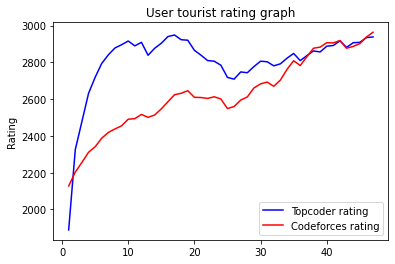

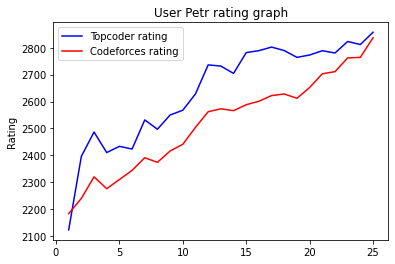

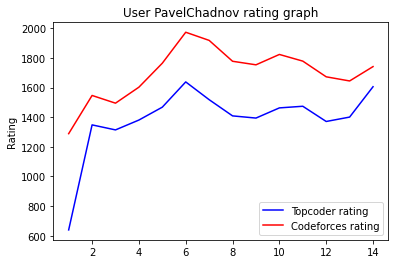

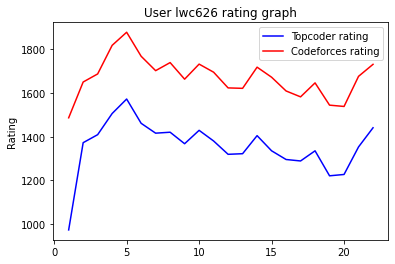

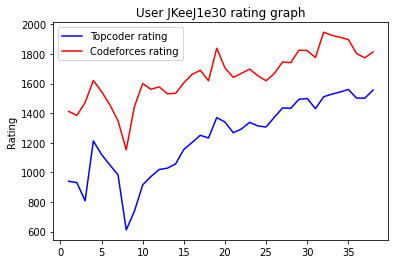

In [58]:
printUserRatingGraph("tourist")
printUserRatingGraph("Petr")
printUserRatingGraph("PavelChadnov")
printUserRatingGraph("lwc626")
printUserRatingGraph("JKeeJ1e30")

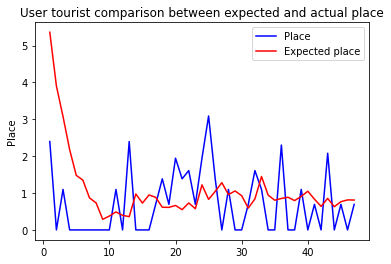

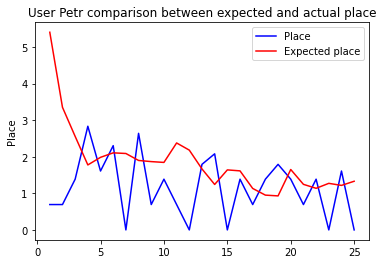

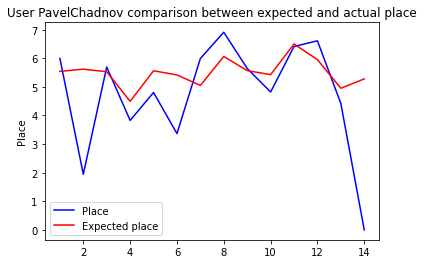

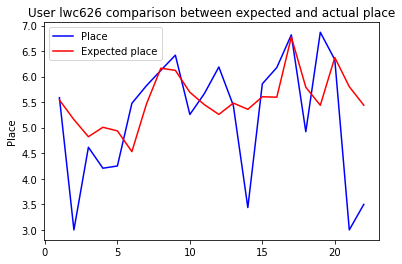

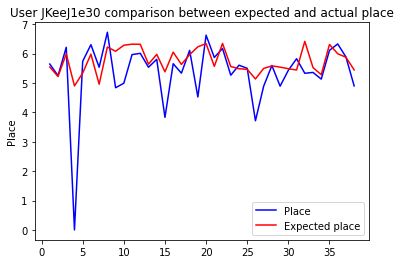

In [56]:
from math import log

printUserPlaces("tourist", placeFun = log)
printUserPlaces("Petr", placeFun = log)
printUserPlaces("PavelChadnov", placeFun = log)
printUserPlaces("lwc626", placeFun = log)
printUserPlaces("JKeeJ1e30", placeFun = log)

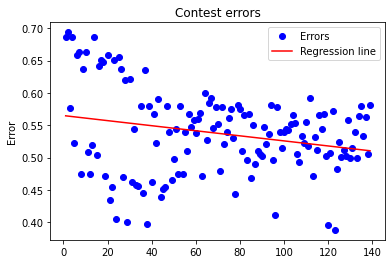

In [55]:
printContestErrors()